In [6]:
import sys
sys.path.append("../..")  
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from langagent.langreason.mcts_utils import get_accuracy
from langagent.langreason.common import load_qa_dataset
from langagent.eval import TreeToJsonl
from langagent.metrics import get_inference_cost_metrics
from langagent.search.node import MCTSNode
from langagent.base_llm import InferenceLogger, VALID_ROLES_PREFIX
with open("data/math500_float_answer_idx_by_level.jsonl", "r") as f:
    loaded_idx_by_level = json.load(f)

 
all_methods = [ "rest", "rest_continuous_bn", "rest_continuous_rm", "rest_continuous_bn_rm" ]
# root_dir = "Qwen3-32B-AWQ_results/gsm8k_rest/rlhflowLogit_Term1008/" # "Meta-Llama-3-8B-Instruct" #
# root_dir = "Qwen3-32B-AWQ_results/math500_rest/run_v0.1.4/" 
# root_dir = "Qwen3-32B-AWQ_results/math500_rest_continuous_bne/run_v0.1.4/"
# root_dir = "Qwen3-32B-AWQ_results/gsm8k_rest/run_v0.1.3/"
# root_dir = "Qwen3-32B-AWQ_results/math500_rap_continuous_bne/run_v0.1.5/"
# root_dir = "Qwen3-32B-AWQ_results/math500_rest_continuous_bne/run_v0.1.4/"

# root_dir = "Qwen3-32B-AWQ_results/gsm8k_rest_continuous_bns/"
# root_dir = "Qwen3-32B-AWQ_results/math500_rest_continuous_bns/"


root_dir = "Meta-Llama-3-8B-Instruct_results/math500_rest/"
# root_dir = "Meta-Llama-3-8B-Instruct_results/math500_rest_continuous_bnd/run_v0.1.5/"
# root_dir = "Meta-Llama-3-8B-Instruct_results/gsm8k_rest_continuous_bnd/run_v0.1.5/"
# root_dir = "Meta-Llama-3-8B-Instruct_results/gsm8k_rest_continuous_bns/run_v0.1.6/"
# root_dir = "Meta-Llama-3-8B-Instruct_results/gsm8k_rest_continuous_bns/run_v0.1.6_bn_qwen/"
# root_dir = "Meta-Llama-3-8B-Instruct_results/math500_rest_continuous_bnd/run_v0.1.5_bn_qwen/"
# root_dir = "Meta-Llama-3-8B-Instruct_results/gsm8k_rest"
# root_dir = "Meta-Llama-3-8B-Instruct_results/gsm8k_rest_continuous_bnd/run_v0.1.5_bn_qwen/"
# root_dir = "Meta-Llama-3-8B-Instruct_results/gsm8k_rest_continuous_bnd/run_v0.1.5_bn_qwen/"

# root_dir = "Meta-Llama-3-8B-Instruct_results/math500_rest_continuous_bns/run_v0.1.6/"
# root_dir = "Meta-Llama-3-8B-Instruct_results/math500_rest_continuous_bns/run_v0.1.6_bn_qwen/"

# root_dir = "Meta-Llama-3-8B_results/math500_rap/"
# root_dir = "Meta-Llama-3-8B_results/math500_rap_continuous_bne/"
# root_dir = "Meta-Llama-3-8B_results/math500_rap_continuous_bns/"
# root_dir = "Meta-Llama-3-8B_results/math500_rap_continuous_bnd"
# root_dir = "Meta-Llama-3-8B_results/gsm8k_rap/"
# root_dir = "Meta-Llama-3-8B_results/gsm8k_rap_continuous_bnd"
# root_dir = "Meta-Llama-3-8B_results/gsm8k_rap_continuous_bnd"
# root_dir = "Meta-Llama-3-8B_results/gsm8k_rap/gsm8k_rap_continuous_bnd/"
# root_dir = "Meta-Llama-3-8B_results/gsm8k_rap/gsm8k_rap_continuous_bne/"
if "math500" in root_dir:
    dataset_name = "math500"
else:
    assert "gsm8k" in root_dir
    dataset_name = "gsm8k" # 

### Helper Functions

In [7]:
def test_regex(results_file):
    import re
    answer = results_file.results[100][0][-1].state[-1].get_answer()       
    extracted = re.match(r'.*[Tt]he answer is .*?([ $.0-9,\-]+)(?:\..*)?', answer, re.DOTALL)[1]
    print("Extracted answer:", extracted)

def generate_metrics(dataset_name, root_dir, extract_method="dfs", exclude_idx=[], include_idx=[]):
    assert type(exclude_idx) == list, "exclude_idx should be a list of indices to exclude."
    assert type(include_idx) == list, "include_idx should be a list of indices to include."

    # accuracy
    full_dataset = load_qa_dataset(dataset_name)
    
    results_file = TreeToJsonl(run_id='', root_dir=root_dir, override=False, node_type=MCTSNode)
    if len(full_dataset) != len(results_file.results):
        print("Size of full dataset:", len(full_dataset))
        print("Size of results file:", len(results_file.results))
        full_dataset = full_dataset[:len(results_file.results)]

        print("Size of full dataset:", len(full_dataset))
    # full_dataset = full_dataset[:58]
    # results_file.results = results_file.results[:58]

    map_new_to_orig_idx = {}
    pred_results = []
    truths = []
    
    for idx, item in enumerate(results_file.results):
        if (not include_idx or idx in include_idx) and (not exclude_idx or idx not in exclude_idx):
            pred_results.append(item)
            truths.append(full_dataset[idx])
            map_new_to_orig_idx[len(pred_results) - 1] = idx
    results_file.results = pred_results

    metrics = get_accuracy(truths, results_file, extract_method, verbose=False)
    metric_all = {}
    metric_all["correct_count"] = metrics["correct_count"]
    metric_all["accuracy"] = round(metrics["accuracy"], 2)

    metric_all["incorrect_indices"] = [map_new_to_orig_idx[new_idx] for new_idx in metrics["incorrect_indices"]]
    metric_all["incorrect_indices_new"] = metrics["incorrect_indices"]
    return results_file, metric_all
    
    # df_rap_correct = get_correct_df(full_dataset, results_file, metrics["incorrect_indices"])
    # df_rap_incorrect = get_incorrect_df(full_dataset, results_file, metrics["incorrect_indices"])

    # print(f"incorrect_indices: {df_rap_incorrect['index'].tolist()}")
    # print(f"incorrect_indices_continuous: {df_rap_incorrect_continuous['index'].tolist()}")

In [8]:

def get_idx_by_depth(results_file):
    idx_depth2 = []
    for idx, final_trace_plus_all in enumerate(results_file.results): 
        # if len(final_trace_plus_all[0]) == 2:
        #     idx_depth2.append(idx)
        all_depth_2 = True
        for trace in final_trace_plus_all:
            if len(trace) > 3:
                all_depth_2 = False
                break
        if all_depth_2:
            idx_depth2.append(idx)

    return idx_depth2

### Token Usage & Accuracy

In [9]:
# print(metrics_acc['incorrect_indices'])
# Incorrect(Qwen3-32B-AWQ_results/math500_rap_continuous_bne/run_v0.1.5): 
# [3, 8, 10, 13, 24, 28, 30, 39, 40, 43, 49,         55,     59, 60, 61, 62, 66, 71, 74,     81, 89,     92, 93, 96, 97, 98]
# Incorrect (Qwen3-32B-AWQ_results/math500_rap/run_v0.1.5)
# [3,    10, 13,                 40, 43, 49, 50, 51, 55, 56, 59,     61, 66,             75,         91, 92, 93, 96, 97, 98]

In [10]:
max_idx=100
if "rap" in root_dir:
    exclude_roles_prefix=["dynamics"]
else:
    exclude_roles_prefix=[]
inference_logger, metrics_efficiency = get_inference_cost_metrics(root_dir, return_metrics=['num_calls', 'input_tokens', 'output_tokens', 'total_hours'], exclude_roles_prefix=exclude_roles_prefix)     # #  include_idx=list(range(50))
print("Total: ", metrics_efficiency)
print('\n\n')
results_file, metrics_acc = generate_metrics(dataset_name, root_dir, extract_method="aggregation", include_idx=list(range(max_idx))) #

metrics_no_incorrect = {k: v for k, v in metrics_acc.items() if k != 'incorrect_indices'}
# print(metrics_acc)
print("Accuracy:", metrics_acc['accuracy'])
print('\n\n')


Result file Meta-Llama-3-8B-Instruct_results/math500_rest/inferencelogger.log already exists. I will append to it. 
Efficiency metrics - Roles
default :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
dynamics :  {'num_calls': '20040', 'input_tokens': '12.94M', 'output_tokens': '40083', 'total_hours': '5.957987036241425'}
policy :  {'num_calls': '3976', 'input_tokens': '2.24M', 'output_tokens': '640752', 'total_hours': '5.4115562371412915'}
evaluator :  {'num_calls': '27245', 'input_tokens': '18.70M', 'output_tokens': '1.79M', 'total_hours': '14.611541125178338'}
bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
Total:  {'num_calls': 51261, 'input_tokens': 33884536, 'output_tokens': 2475204, 'total_hours': 25.98}



Result file Meta-Llama-3-8B-Instruct_results/math500_rest/treetojsonl.jsonl already exists. Lo

### RAP Results (LlaMa)

In [ ]:
# RAP Inference Cost on GSM8K (Llama)
# CoT
# {'num_calls': 100, 'input_tokens': 12150, 'output_tokens': 69422, 'total_hours': 0.57}
# Accuracy: 0.32

# RAP
# dynamics :  {'num_calls': '5874', 'input_tokens': '7.88M', 'output_tokens': '547606', 'total_hours': '4.812323867413733'}
# policy :  {'num_calls': '4606', 'input_tokens': '6.21M', 'output_tokens': '67750', 'total_hours': '0.6946295700470606'}
# evaluator :  {'num_calls': '3031', 'input_tokens': '1.93M', 'output_tokens': '0', 'total_hours': '0.023451659546958076'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  {'num_calls': 13511, 'input_tokens': 16019831, 'output_tokens': 615356, 'total_hours': 5.53}
# Accuracy: 0.61

# +BN-SC (Qwen)
# dynamics :  {'num_calls': '1689', 'input_tokens': '2.11M', 'output_tokens': '137738', 'total_hours': '1.227164795729849'}
# policy :  {'num_calls': '1388', 'input_tokens': '1.76M', 'output_tokens': '23529', 'total_hours': '0.23820450332429674'}
# evaluator :  {'num_calls': '764', 'input_tokens': '488888', 'output_tokens': '0', 'total_hours': '0.006171819501452976'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '2499', 'input_tokens': '476193', 'output_tokens': '40693', 'total_hours': '1.4122255841228697'}
# Total:  {'num_calls': 6340, 'input_tokens': 4834254, 'output_tokens': 201960, 'total_hours': 2.88}
# Accuracy: 0.48

# +BN-SC2 (Qwen)
# dynamics :  {'num_calls': '1224', 'input_tokens': '1.72M', 'output_tokens': '75525', 'total_hours': '0.659518061876297'}
# policy :  {'num_calls': '1128', 'input_tokens': '1.57M', 'output_tokens': '14855', 'total_hours': '0.15275277952353158'}
# evaluator :  {'num_calls': '486', 'input_tokens': '303953', 'output_tokens': '0', 'total_hours': '0.003815523386001587'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '1404', 'input_tokens': '387606', 'output_tokens': '2808', 'total_hours': '0.24390751176410252'}
# Total:  {'num_calls': 4242, 'input_tokens': 3981374, 'output_tokens': 93188, 'total_hours': 1.06}
# Accuracy: 0.46

# +BN-DP (Qwen)
# dynamics :  {'num_calls': '1410', 'input_tokens': '2.08M', 'output_tokens': '124069', 'total_hours': '1.094430981874466'}
# policy :  {'num_calls': '625', 'input_tokens': '910324', 'output_tokens': '7739', 'total_hours': '0.0826034250524309'}
# evaluator :  {'num_calls': '549', 'input_tokens': '343306', 'output_tokens': '0', 'total_hours': '0.004295610388120015'}
# bn_eval :  {'num_calls': '380', 'input_tokens': '114298', 'output_tokens': '760', 'total_hours': '0.07070127454068925'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  {'num_calls': 2964, 'input_tokens': 3443592, 'output_tokens': 132568, 'total_hours': 1.25}
# Accuracy: 0.57

# RAP Inference Cost on Math500 (Llama)
# CoT
# {'num_calls': 100, 'input_tokens': 12911, 'output_tokens': 71166, 'total_hours': 0.57}
# Accuracy: 0.17

# RAP
# dynamics :  {'num_calls': '4569', 'input_tokens': '5.73M', 'output_tokens': '856024', 'total_hours': '7.346069217854076'}
# policy :  {'num_calls': '3583', 'input_tokens': '4.47M', 'output_tokens': '70390', 'total_hours': '0.6681121156613032'}
# evaluator :  {'num_calls': '2275', 'input_tokens': '1.54M', 'output_tokens': '0', 'total_hours': '0.01760061734252506'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  {'num_calls': 10427, 'input_tokens': 11744856, 'output_tokens': 926414, 'total_hours': 8.03}
# Accuracy: 0.18

# +BN-SC (Qwen)
# default :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# dynamics :  {'num_calls': '2808', 'input_tokens': '6.64M', 'output_tokens': '513531', 'total_hours': '4.461865185234282'}
# policy :  {'num_calls': '2347', 'input_tokens': '5.64M', 'output_tokens': '56670', 'total_hours': '0.6076139258676105'}
# evaluator :  {'num_calls': '1398', 'input_tokens': '1.01M', 'output_tokens': '0', 'total_hours': '0.011323635379473368'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '4512', 'input_tokens': '1.66M', 'output_tokens': '77161', 'total_hours': '2.763352615435918'}
# Total:  {'num_calls': 11065, 'input_tokens': 14934614, 'output_tokens': 647362, 'total_hours': 7.84}
# Accuracy: 0.27

# +BN-SC2 (Qwen)
# dynamics :  {'num_calls': '1629', 'input_tokens': '2.65M', 'output_tokens': '297535', 'total_hours': '2.5612628561258317'}
# policy :  {'num_calls': '1449', 'input_tokens': '2.31M', 'output_tokens': '25785', 'total_hours': '0.25825371199183994'}
# evaluator :  {'num_calls': '713', 'input_tokens': '481282', 'output_tokens': '0', 'total_hours': '0.00570312605963813'}
# bn_eval :  {'num_calls': '0', 'input_tokeZns': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '1773', 'input_tokens': '622950', 'output_tokens': '3546', 'total_hours': '0.3584575439823998'}
# Total:  {'num_calls': 5564, 'input_tokens': 6062158, 'output_tokens': 326866, 'total_hours': 3.18}
# Accuracy: 0.21

# +BN-DP (Qwen)
# dynamics :  {'num_calls': '1341', 'input_tokens': '1.62M', 'output_tokens': '341636', 'total_hours': '2.9448487955994076'}
# policy :  {'num_calls': '697', 'input_tokens': '830620', 'output_tokens': '14698', 'total_hours': '0.13668952021333908'}
# evaluator :  {'num_calls': '585', 'input_tokens': '395294', 'output_tokens': '0', 'total_hours': '0.0045140657822291055'}
# bn_eval :  {'num_calls': '298', 'input_tokens': '102992', 'output_tokens': '596', 'total_hours': '0.0617539068725374'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  {'num_calls': 2921, 'input_tokens': 2948801, 'output_tokens': 356930, 'total_hours': 3.15}
# Accuracy: 0.26


### ReST Results (LlaMa)

In [ ]:
# Rest Inference Cost on GSM8K (Llama)

# CoT
# Accuracy: 0.76  (aggregation) 0.76 (dfs)# CoT
# {'num_calls': 100, 'input_tokens': 20476, 'output_tokens': 20041, 'total_hours': 0.16}
# Accuracy: 0.68

# Rest
# dynamics :  {'num_calls': '9730', 'input_tokens': '4.06M', 'output_tokens': '19461', 'total_hours': '2.314823047121366'}
# policy :  {'num_calls': '1828', 'input_tokens': '684735', 'output_tokens': '130388', 'total_hours': '1.0633851390414768'}
# evaluator :  {'num_calls': '16080', 'input_tokens': '7.02M', 'output_tokens': '868615', 'total_hours': '7.06318093544907'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  {'num_calls': 27638, 'input_tokens': 11758581, 'output_tokens': 1018464, 'total_hours': 10.44}
# Accuracy: 0.82 (aggregation) 0.8 (dfs)

# +BN-SC
# dynamics :  {'num_calls': '5920', 'input_tokens': '2.54M', 'output_tokens': '11840', 'total_hours': '1.4473813282781176'}
# policy :  {'num_calls': '1352', 'input_tokens': '519124', 'output_tokens': '100699', 'total_hours': '0.8329761435588201'}
# evaluator :  {'num_calls': '7105', 'input_tokens': '3.23M', 'output_tokens': '414163', 'total_hours': '3.4172429659631516'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '4443', 'input_tokens': '1.15M', 'output_tokens': '127575', 'total_hours': '1.0448733039697011'}
# Total:  {'num_calls': 18820, 'input_tokens': 7431342, 'output_tokens': 654277, 'total_hours': 6.74}
# Accuracy: 0.7 (dfs)

# +BN-SC2
# dynamics :  {'num_calls': '3510', 'input_tokens': '1.77M', 'output_tokens': '7020', 'total_hours': '0.9694471424155765'}
# policy :  {'num_calls': '960', 'input_tokens': '407910', 'output_tokens': '68015', 'total_hours': '0.5635315018892288'}
# evaluator :  {'num_calls': '3543', 'input_tokens': '1.84M', 'output_tokens': '195560', 'total_hours': '1.618975911868943'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '2346', 'input_tokens': '993141', 'output_tokens': '4692', 'total_hours': '0.05745414819982317'}
# Total:  {'num_calls': 10359, 'input_tokens': 5010576, 'output_tokens': 275287, 'total_hours': 3.21}
# Accuracy: 0.73 (dfs)

# +BN-DP
# dynamics :  {'num_calls': '3260', 'input_tokens': '1.42M', 'output_tokens': '6520', 'total_hours': '0.8107292178604338'}
# policy :  {'num_calls': '406', 'input_tokens': '158505', 'output_tokens': '29414', 'total_hours': '0.24755442188845742'}
# evaluator :  {'num_calls': '3212', 'input_tokens': '1.41M', 'output_tokens': '187380', 'total_hours': '1.5679535830683178'}
# bn_eval :  {'num_calls': '272', 'input_tokens': '107550', 'output_tokens': '544', 'total_hours': '0.007172575791676839'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  {'num_calls': 7150, 'input_tokens': 3089812, 'output_tokens': 223858, 'total_hours': 2.63}
# Accuracy: 0.68 (dfs)


# +BN-SC (Qwen)
# dynamics :  {'num_calls': '4590', 'input_tokens': '1.85M', 'output_tokens': '9180', 'total_hours': '1.0681943624549441'}
# policy :  {'num_calls': '1082', 'input_tokens': '387528', 'output_tokens': '76909', 'total_hours': '0.6335879066917631'}
# evaluator :  {'num_calls': '5657', 'input_tokens': '2.45M', 'output_tokens': '324898', 'total_hours': '2.6608969942728677'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '2823', 'input_tokens': '810885', 'output_tokens': '66274', 'total_hours': '2.3045281453265085'}
# Total:  {'num_calls': 14152, 'input_tokens': 5492172, 'output_tokens': 477261, 'total_hours': 6.67}
# Accuracy: 0.83 (aggregation)  0.84 (dfs)

# +BN-SC2 (Qwen)
# dynamics :  {'num_calls': '3130', 'input_tokens': '1.53M', 'output_tokens': '6260', 'total_hours': '0.7882329579856661'}
# policy :  {'num_calls': '875', 'input_tokens': '359735', 'output_tokens': '65026', 'total_hours': '0.5385638548930486'}
# evaluator :  {'num_calls': '3154', 'input_tokens': '1.59M', 'output_tokens': '177692', 'total_hours': '1.4695486097865635'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '2316', 'input_tokens': '1.06M', 'output_tokens': '4632', 'total_hours': '0.5840394794278675'}
# Total:  {'num_calls': 9475, 'input_tokens': 4541904, 'output_tokens': 253610, 'total_hours': 3.38}
# Accuracy: 0.80 (dfs)

# +BN-DP (Qwen)
# dynamics :  {'num_calls': '3010', 'input_tokens': '1.36M', 'output_tokens': '6021', 'total_hours': '0.7676456552081637'}
# policy :  {'num_calls': '354', 'input_tokens': '144113', 'output_tokens': '27587', 'total_hours': '0.22816818137963613'}
# evaluator :  {'num_calls': '3062', 'input_tokens': '1.43M', 'output_tokens': '171514', 'total_hours': '1.4126941465006935'}
# bn_eval :  {'num_calls': '267', 'input_tokens': '110741', 'output_tokens': '534', 'total_hours': '0.06346631871329414'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  {'num_calls': 6693, 'input_tokens': 3042297, 'output_tokens': 205656, 'total_hours': 2.47}
# Accuracy: 0.76 (aggregation) 0.76 (dfs)


# Rest Inference Cost on Math500 (Llama)

# CoT
# {'num_calls': 316, 'input_tokens': 66647, 'output_tokens': 121463, 'total_hours': 1.01}
# Accuracy: 0.34

# Rest
# dynamics :  {'num_calls': '20040', 'input_tokens': '12.94M', 'output_tokens': '40083', 'total_hours': '5.957987036241425'}
# policy :  {'num_calls': '3976', 'input_tokens': '2.24M', 'output_tokens': '640752', 'total_hours': '5.4115562371412915'}
# evaluator :  {'num_calls': '27245', 'input_tokens': '18.70M', 'output_tokens': '1.79M', 'total_hours': '14.611541125178338'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  {'num_calls': 51261, 'input_tokens': 33884536, 'output_tokens': 2475204, 'total_hours': 25.98}
# Accuracy: 0.37 (aggregation) 0.35 (dfs)

# +BN-SC
# dynamics :  {'num_calls': '14660', 'input_tokens': '8.98M', 'output_tokens': '29321', 'total_hours': '4.185041209724214'}
# policy :  {'num_calls': '3281', 'input_tokens': '1.80M', 'output_tokens': '491423', 'total_hours': '4.20253364165624'}
# evaluator :  {'num_calls': '16201', 'input_tokens': '10.80M', 'output_tokens': '1.15M', 'total_hours': '9.375491427183151'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '17895', 'input_tokens': '4.70M', 'output_tokens': '382716', 'total_hours': '3.1253772118356493'}
# Total:  {'num_calls': 52037, 'input_tokens': 26272764, 'output_tokens': 2055283, 'total_hours': 20.89}
# Accuracy: 0.32  (aggregation) 0.33 (dfs)

# +BN-SC2
# dynamics :  {'num_calls': '7300', 'input_tokens': '5.66M', 'output_tokens': '14600', 'total_hours': '2.0851515276564494'}
# policy :  {'num_calls': '1944', 'input_tokens': '1.31M', 'output_tokens': '238470', 'total_hours': '1.9806847732596928'}
# evaluator :  {'num_calls': '6017', 'input_tokens': '5.16M', 'output_tokens': '400158', 'total_hours': '3.3349581256839964'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '4224', 'input_tokens': '3.02M', 'output_tokens': '8448', 'total_hours': '0.12633781572182973'}
# Total:  {'num_calls': 19485, 'input_tokens': 15159446, 'output_tokens': 661676, 'total_hours': 7.53}
# Accuracy: 0.29 (dfs)


# +BN-DP
# dynamics :  {'num_calls': '5400', 'input_tokens': '4.02M', 'output_tokens': '10800', 'total_hours': '1.4932288053300646'}
# policy :  {'num_calls': '731', 'input_tokens': '480536', 'output_tokens': '112768', 'total_hours': '0.9541713734467824'}
# evaluator :  {'num_calls': '4866', 'input_tokens': '3.83M', 'output_tokens': '313036', 'total_hours': '2.580568951368332'}
# bn_eval :  {'num_calls': '419', 'input_tokens': '279460', 'output_tokens': '838', 'total_hours': '0.011792139278517829'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  {'num_calls': 11416, 'input_tokens': 8613407, 'output_tokens': 437442, 'total_hours': 5.04}
# Accuracy: 0.35 (aggregation) 0.36 (dfs)

# +BN-SC (Qwen)
# dynamics :  {'num_calls': '7814', 'input_tokens': '4.54M', 'output_tokens': '15629', 'total_hours': '2.183949909210205'}
# policy :  {'num_calls': '1722', 'input_tokens': '887092', 'output_tokens': '221065', 'total_hours': '1.8066992529233297'}
# evaluator :  {'num_calls': '8505', 'input_tokens': '5.38M', 'output_tokens': '612150', 'total_hours': '5.002640137407515'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '6009', 'input_tokens': '1.90M', 'output_tokens': '108070', 'total_hours': '3.8752877820862666'}
# Total:  {'num_calls': 24050, 'input_tokens': 12709011, 'output_tokens': 956914, 'total_hours': 12.87}
# Accuracy: 0.38 (aggregation) 0.43 (dfs) 

# +BN-SC2 (Qwen)
# dynamics :  {'num_calls': '8290', 'input_tokens': '5.81M', 'output_tokens': '16582', 'total_hours': '2.4678987918959723'}
# policy :  {'num_calls': '2053', 'input_tokens': '1.24M', 'output_tokens': '385965', 'total_hours': '3.2039668668640986'}
# evaluator :  {'num_calls': '8516', 'input_tokens': '6.40M', 'output_tokens': '615444', 'total_hours': '5.020814937419361'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '4446', 'input_tokens': '3.23M', 'output_tokens': '8892', 'total_hours': '1.3124906773037381'}
# Total:  {'num_calls': 23305, 'input_tokens': 16683196, 'output_tokens': 1026883, 'total_hours': 12.01}
# Accuracy: 0.34 (dfs) 

# +BN-DP (Qwen)
# dynamics :  {'num_calls': '7870', 'input_tokens': '5.60M', 'output_tokens': '15740', 'total_hours': '2.32432218545013'}
# policy :  {'num_calls': '1285', 'input_tokens': '809498', 'output_tokens': '213354', 'total_hours': '1.776058592134052'}
# evaluator :  {'num_calls': '8213', 'input_tokens': '6.05M', 'output_tokens': '586894', 'total_hours': '4.8683194886313546'}
# bn_eval :  {'num_calls': '462', 'input_tokens': '295849', 'output_tokens': '924', 'total_hours': '0.13562518894672393'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  {'num_calls': 17830, 'input_tokens': 12755844, 'output_tokens': 816912, 'total_hours': 9.1}
# Accuracy: 0.36 (aggregation)  0.37 (dfs)




### RAP results (Qwen)

In [ ]:
# RAP Inference Cost on Math500 (Qwen)
# CoT
# default :  {'num_calls': '100', 'input_tokens': '21181', 'output_tokens': '78088', 'total_hours': '1.6107676876915826'}
# Accuracy:0.79

# RAP
# dynamics :  {'num_calls': '5112', 'input_tokens': '7.28M', 'output_tokens': '358960', 'total_hours': '9.82342485083474'}
# policy :  {'num_calls': '4369', 'input_tokens': '6.18M', 'output_tokens': '80860', 'total_hours': '2.338502582642767'}
# evaluator :  {'num_calls': '2635', 'input_tokens': '1.91M', 'output_tokens': '0', 'total_hours': '0.5154868837859895'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  {'num_calls': 12116, 'input_tokens': 15366566, 'output_tokens': 439820, 'total_hours': 12.68}
# 0.81

# +BN-SC
# dynamics :  {'num_calls': '2622', 'input_tokens': '4.30M', 'output_tokens': '217031', 'total_hours': '6.504800891743766'}
# policy :  {'num_calls': '2340', 'input_tokens': '3.80M', 'output_tokens': '42665', 'total_hours': '1.273353127969636'}
# evaluator :  {'num_calls': '1262', 'input_tokens': '916020', 'output_tokens': '0', 'total_hours': '0.24627328111065758'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '3057', 'input_tokens': '677583', 'output_tokens': '48798', 'total_hours': '1.1749374555879168'}
# Total:  {'num_calls': 9281, 'input_tokens': 9690373, 'output_tokens': 308494, 'total_hours': 9.2}
# Accuracy:0.73

# +BN-DP 
# dynamics :  {'num_calls': '1278', 'input_tokens': '1.82M', 'output_tokens': '79812', 'total_hours': '1.8073309583796395'}
# policy :  {'num_calls': '595', 'input_tokens': '840228', 'output_tokens': '10585', 'total_hours': '0.30951525224579707'}
# evaluator :  {'num_calls': '510', 'input_tokens': '360410', 'output_tokens': '0', 'total_hours': '0.097117613752683'}
# bn_eval :  {'num_calls': '337', 'input_tokens': '116408', 'output_tokens': '674', 'total_hours': '0.05119572944111294'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  { 'total_hours': 2.26}
# 0.80




In [44]:
exclude_idx = []
incorrect_idx_cot = [3, 5, 8, 9, 12, 13, 17, 18, 27, 28, 30, 31, 33, 35, 36, 37, 38, 39, 43, 48, 49, 52, 55, 57, 60, 66, 68, 69, 71, 74, 75, 78, 80, 81, 82, 85, 86, 89, 91, 93, 95, 98, 99]
max_idx = 100
for level in range(1, 6):
    include_idx = loaded_idx_by_level.get(str(level), [])
    # if max_idx:
    #     include_idx = [i for i in include_idx if i < max_idx]
    print(f"Level: {level}")
    inference_logger, metrics_efficiency = get_inference_cost_metrics(root_dir, include_idx=include_idx, return_metrics=[ 'total_hours'], exclude_roles_prefix=["dynamics"], verbose=False)     #  include_idx=list(range(50))
    print("Total: ", metrics_efficiency)
    # results_file, metrics_acc = generate_metrics(dataset_name, root_dir, extract_method="aggregation", include_idx=list(range(max_idx))) #
    # print("Accuracy:", metrics_acc['accuracy'])
    # print('')
    
    

Level: 1
Result file Qwen3-32B-AWQ_results/math500_rest_continuous_bne/run_v0.1.4/inferencelogger.log already exists. I will append to it. 
Total:  {'total_hours': 0.2}
Level: 2
Result file Qwen3-32B-AWQ_results/math500_rest_continuous_bne/run_v0.1.4/inferencelogger.log already exists. I will append to it. 
Total:  {'total_hours': 0.52}
Level: 3
Result file Qwen3-32B-AWQ_results/math500_rest_continuous_bne/run_v0.1.4/inferencelogger.log already exists. I will append to it. 
Total:  {'total_hours': 2.4}
Level: 4
Result file Qwen3-32B-AWQ_results/math500_rest_continuous_bne/run_v0.1.4/inferencelogger.log already exists. I will append to it. 
Total:  {'total_hours': 3.39}
Level: 5
Result file Qwen3-32B-AWQ_results/math500_rest_continuous_bne/run_v0.1.4/inferencelogger.log already exists. I will append to it. 
Total:  {'total_hours': 2.46}


## ReST Results (Qwen)

In [ ]:

# ReST Inference Cost on Math500 (Qwen)

# CoT
# default :  {'num_calls': '100', 'input_tokens': '21181', 'output_tokens': '78088', 'total_hours': '1.6107676876915826'}
# Accuracy:0.79

# ReST
# dynamics :  {'num_calls': '8190', 'input_tokens': '6.46M', 'output_tokens': '16381', 'total_hours': '1.9344405606057908'}
# policy :  {'num_calls': '1574', 'input_tokens': '1.02M', 'output_tokens': '490990', 'total_hours': '11.98260814540916'}
# evaluator :  {'num_calls': '1510', 'input_tokens': '1.02M', 'output_tokens': '0', 'total_hours': '0.010779098338550992'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  {'num_calls': 3084, 'input_tokens': 2045934, 'output_tokens': 490990, 'total_hours': 11.99}
# Accuracy:0.87

# +BN-SC
# default :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# dynamics :  {'num_calls': '3730', 'input_tokens': '2.49M', 'output_tokens': '7460', 'total_hours': '0.7549590470393499'}
# policy :  {'num_calls': '886', 'input_tokens': '444830', 'output_tokens': '287916', 'total_hours': '7.553702143960529'}
# evaluator :  {'num_calls': '553', 'input_tokens': '316861', 'output_tokens': '0', 'total_hours': '0.003422197699546814'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '1719', 'input_tokens': '1.04M', 'output_tokens': '59623', 'total_hours': '1.4117869194348653'}
# Total:  {'num_calls': 3158, 'input_tokens': 1800363, 'output_tokens': 347539, 'total_hours': 8.97}
# Accuracy:0.84

# +BN-SC2
# dynamics :  {'num_calls': '2280', 'input_tokens': '1.83M', 'output_tokens': '4560', 'total_hours': '0.5284486120939255'}
# policy :  {'num_calls': '661', 'input_tokens': '379758', 'output_tokens': '192886', 'total_hours': '4.929485832121637'}
# evaluator :  {'num_calls': '1282', 'input_tokens': '918622', 'output_tokens': '2529', 'total_hours': '0.25157617032527924'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '1830', 'input_tokens': '1.56M', 'output_tokens': '3660', 'total_hours': '0.4397247730361091'}
# Total:  {'num_calls': 6053, 'input_tokens': 4684791, 'output_tokens': 203635, 'total_hours': 6.15}
# Accuracy:0.85

# +BN-DP
# dynamics :  {'num_calls': '2180', 'input_tokens': '2.10M', 'output_tokens': '4360', 'total_hours': '0.5357373050848643'}
# policy :  {'num_calls': '238', 'input_tokens': '227927', 'output_tokens': '86443', 'total_hours': '2.0572017274300256'}
# evaluator :  {'num_calls': '229', 'input_tokens': '197129', 'output_tokens': '0', 'total_hours': '0.0019460597303178576'}
# bn_eval :  {'num_calls': '208', 'input_tokens': '164228', 'output_tokens': '416', 'total_hours': '0.04756647818618351'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  {'num_calls': 675, 'input_tokens': 589284, 'output_tokens': 86859, 'total_hours': 2.11}
# Accuracy: 0.89


# Inference Cost on GSM8K (Qwen)
# CoT 
# policy :  {'num_calls': 100, 'input_tokens': 20417, 'output_tokens': 46216, 'total_hours': 0.96}
# Accuracy: 0.96

# ReST
# dynamics :  {'num_calls': '4630', 'input_tokens': '1.90M', 'output_tokens': '9260', 'total_hours': '0.8419223002592723'}
# policy :  {'num_calls': '836', 'input_tokens': '299571', 'output_tokens': '83463', 'total_hours': '1.9759868122471704'}
# evaluator :  {'num_calls': '817', 'input_tokens': '182052', 'output_tokens': '0', 'total_hours': '0.005039480792151557'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  {'num_calls': 1653, 'input_tokens': 481623, 'output_tokens': 83463, 'total_hours': 1.98}
# Accuracy: 0.97

# +BN-SC
# default :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# dynamics :  {'num_calls': '2440', 'input_tokens': '879610', 'output_tokens': '4880', 'total_hours': '0.38412017318937514'}
# policy :  {'num_calls': '605', 'input_tokens': '196981', 'output_tokens': '61224', 'total_hours': '1.299027090469996'}
# evaluator :  {'num_calls': '324', 'input_tokens': '57528', 'output_tokens': '0', 'total_hours': '0.0017206921842363146'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '1077', 'input_tokens': '411597', 'output_tokens': '39201', 'total_hours': '0.9160338296492895'}
# Total:  {'num_calls': 2006, 'input_tokens': 666106, 'output_tokens': 100425, 'total_hours': 2.22}
# Accuracy: 0.97

# +BN-SC2
# dynamics :  {'num_calls': '1570', 'input_tokens': '640170', 'output_tokens': '3141', 'total_hours': '0.27253242512543996'}
# policy :  {'num_calls': '468', 'input_tokens': '154494', 'output_tokens': '48748', 'total_hours': '1.0132399042447409'}
# evaluator :  {'num_calls': '912', 'input_tokens': '296628', 'output_tokens': '1826', 'total_hours': '0.1266174609131283'}
# bn_eval :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# bn_entropy :  {'num_calls': '1377', 'input_tokens': '604788', 'output_tokens': '2754', 'total_hours': '0.25258405917220644'}
# Total:  {'num_calls': 4327, 'input_tokens': 1696080, 'output_tokens': 56469, 'total_hours': 1.66}
# Accuracy: 0.97

# +BN-DP
# dynamics :  {'num_calls': '1630', 'input_tokens': '663610', 'output_tokens': '3261', 'total_hours': '0.2822738133536445'}
# policy :  {'num_calls': '166', 'input_tokens': '55754', 'output_tokens': '16984', 'total_hours': '0.3621453430917528'}
# evaluator :  {'num_calls': '166', 'input_tokens': '31320', 'output_tokens': '0', 'total_hours': '0.000895939999156528'}
# bn_eval :  {'num_calls': '161', 'input_tokens': '62545', 'output_tokens': '322', 'total_hours': '0.026799815032217237'}
# bn_entropy :  {'num_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'total_hours': '0.0'}
# Total:  {'num_calls': 493, 'input_tokens': 149619, 'output_tokens': 17306, 'total_hours': 0.39}
# Accuracy: 0.97

In [ ]:
# Inference Cost on Math500 (Qwen)
# ReST
# Level: 1
# Total:  {'total_hours': 0.32}
# Level: 2
# Total:  {'total_hours': 0.65}
# Level: 3
# Total:  {'total_hours': 3.32}
# Level: 4
# Total:  {'total_hours': 3.01}
# Level: 5
# Total:  {'total_hours': 4.69}

# +BN-SC
# Level: 1
# Total:  {'total_hours': 0.2}
# Level: 2
# Total:  {'total_hours': 0.52}
# Level: 3
# Total:  {'total_hours': 2.4}
# Level: 4
# Total:  {'total_hours': 3.39}
# Level: 5
# Total:  {'total_hours': 2.46}

### Find Incorrect Index

In [4]:
run_id, root_dir1 = get_run_id_and_root_dir(dataset_name, method, model_name, dat, sub_dir="rlhflowLogit_Term1008")
run_id, root_dir_debug = get_run_id_and_root_dir(dataset_name, method, model_name, dat, sub_dir="exploration_runs/rlhflowLogit_TermORM09")
# rlhflowLogit_critic_Term1008_SearchTerm08
# rlhflowLogit_Term100809
# rlhflowLogit_Term09
# rlhflowLogit_TermORM09

max_idx = 100
for level in range(1, 6):
    print("Level", level)
    include_idx = loaded_idx_by_level.get(str(level), [])
    include_idx = [idx for idx in include_idx if idx < max_idx]
    results_file, metrics_base = generate_metrics(dataset_name, root_dir1, extract_method="aggregation", include_idx=include_idx)
    results_file, metrics_debug = generate_metrics(dataset_name, root_dir_debug, extract_method="aggregation", include_idx=include_idx)
    print(metrics_base['accuracy'])
    print(metrics_debug['accuracy'])
    print([idx for idx in metrics_debug['incorrect_indices'] if idx not in metrics_base['incorrect_indices']])
    print('\n\n\n')

print("All levels combined")
results_file, metrics_base = generate_metrics(dataset_name, root_dir1, include_idx=list(range(100)))
results_file, metrics_debug = generate_metrics(dataset_name, root_dir_debug, include_idx=list(range(100)))
print(metrics_base['accuracy'])
print(metrics_debug['accuracy'])
# print([idx for idx in metrics_debug['incorrect_indices'] if idx not in metrics_base['incorrect_indices']])

Level 1
Result file Meta-Llama-3-8B-Instruct_results/math500_rest_nAct3_nIter50_m2/rlhflowLogit_Term1008/inferencelogger.log already exists. I will append to it. 
default :  {'num_calls': '0', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'running_time': '0'}
dynamics :  {'num_calls': '25474', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '14.03M', 'output_tokens': '50962', 'running_time': '2176.8269329071045'}
policy :  {'num_calls': '3984', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '2.00M', 'output_tokens': '747515', 'running_time': '22985.25967645645'}
evaluator :  {'num_calls': '3928', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '1.72M', 'output_tokens': '0', 'running_time': '194.3758749961853'}
expand :  {'num_calls': '21101', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '10.61M', 'output_tokens': '638639', 'running_time': '20163.031200408936'}
simu

### Original vs BN vs RM vs BN-RM
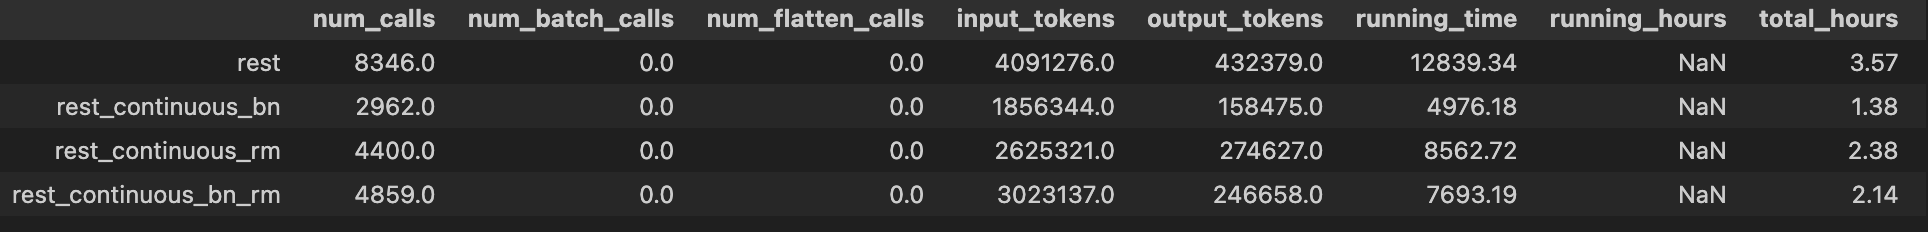

In [ ]:
metrics_for_all_methods = {}
for method in all_methods:
     metrics = generate_metrics(dataset_name, method, model_name, dat)
     metrics_for_all_methods[method] = metrics
import pandas as pd
df_result = pd.DataFrame(metrics_for_all_methods).T

AssertionError: Root directory Meta-Llama-3-8B-Instruct_results/math500_rest/ does not exist. Please check the run_id and model_name.

In [12]:
df_result

,num_calls,num_batch_calls,num_flatten_calls,input_tokens,output_tokens,running_time,running_hours,total_hours,accuracy
rest,8346.0,0.0,0.0,4091276.0,432379.0,12839.34,NaN,3.57,0.27
rest_continuous_bn,2962.0,0.0,0.0,1856344.0,158475.0,4976.18,NaN,1.38,0.23
rest_continuous_rm,4400.0,0.0,0.0,2625321.0,274627.0,8562.72,NaN,2.38,0.23
rest_continuous_bn_rm,4859.0,0.0,0.0,3023137.0,246658.0,7693.19,NaN,2.14,0.24


In [ ]:
# llama_rest_gsm8k: 3.95H/0.588
# expand :  {'num_calls': '2638', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '654400', 'output_tokens': '118361', 'running_time': '3048.940145969391'}
# simulate :  {'num_calls': '13941', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '7.33M', 'output_tokens': '417492', 'running_time': '11169.780436038971'}
# continuation :  {'num_calls': '0', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '0', 'output_tokens': '0', 'running_time': '0'}

# llama_rest_bn_gsm8k: 5.32H/0.596
# expand :  {'num_calls': '1693', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '812951', 'output_tokens': '51950', 'running_time': '1369.6597769260406'}
# simulate :  {'num_calls': '5036', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '3.63M', 'output_tokens': '159701', 'running_time': '4325.293148756027'}
# continuation :  {'num_calls': '15554', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '7.73M', 'output_tokens': '510359', 'running_time': '13480.74155163765'}


# llama_rest_rm_gsm8k: 7.27H/0.606
# expand :  {'num_calls': '5052', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '2.09M', 'output_tokens': '154043', 'running_time': '4085.656162261963'}
# simulate :  {'num_calls': '15779', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '10.28M', 'output_tokens': '453713', 'running_time': '12421.689930677414'}
# continuation :  {'num_calls': '11027', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '4.06M', 'output_tokens': '367061', 'running_time': '9673.724572658539'}

# llama_rest_bn_rm_gsm8k: 7.09H/0.603
# expand :  {'num_calls': '4977', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '2.06M', 'output_tokens': '155017', 'running_time': '4050.0857660770416'}
# simulate :  {'num_calls': '15615', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '9.90M', 'output_tokens': '450154', 'running_time': '12089.097029447556'}
# continuation :  {'num_calls': '10853', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '3.96M', 'output_tokens': '361252', 'running_time': '9379.610668420792'}

# Summary:
# 1. Continuation with rm (rm+bn) leads to more expansion and simulations but also more accutate results

# llama_rest_bn_math500: 2.96H/0.25
# expand :  {'num_calls': '352', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '183432', 'output_tokens': '15852', 'running_time': '490.9305248260498'}
# simulate :  {'num_calls': '1220', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '1.11M', 'output_tokens': '47662', 'running_time': '1500.61536693573'}
# continuation :  {'num_calls': '3765', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '2.64M', 'output_tokens': '277984', 'running_time': '8668.772117376328'}

# llama_rest_bn_rm_math500: 4.07H/0.268
# expand :  {'num_calls': '1192', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '652302', 'output_tokens': '71326', 'running_time': '2187.2717044353485'}
# simulate :  {'num_calls': '4192', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '3.98M', 'output_tokens': '241397', 'running_time': '7505.041634321213'}
# continuation :  {'num_calls': '2561', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '1.19M', 'output_tokens': '161926', 'running_time': '4964.981756687164'}

# llama_rest_bn_rm_math500: 4.75H/0.285
# expand :  {'num_calls': '1215', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '641629', 'output_tokens': '70722', 'running_time': '2161.587968111038'}
# simulate :  {'num_calls': '4724', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '5.37M', 'output_tokens': '290639', 'running_time': '9620.811433553696'}
# continuation :  {'num_calls': '2563', 'num_batch_calls': '0', 'num_flatten_calls': '0', 'input_tokens': '1.17M', 'output_tokens': '171003', 'running_time': '5329.562162399292'}


### Instance-Specific Analysis

In [ ]:


run_id1, root_dir1 = get_run_id_and_root_dir(dataset_name, "rest" , model_name, dat)
run_id2, root_dir2 = get_run_id_and_root_dir(dataset_name, "rest_continuous_bn" , model_name, dat)
run_id3, root_dir3 = get_run_id_and_root_dir(dataset_name, "rest_continuous_rm" , model_name, dat)
run_id4, root_dir4 = get_run_id_and_root_dir(dataset_name, "rest_continuous_bn_rm" , model_name, dat)


inference_logger_rest = InferenceLogger(run_id=run_id1, root_dir=root_dir1)
inference_logger_rest_bn = InferenceLogger(run_id=run_id2, root_dir=root_dir2)
inference_logger_rest_rm = InferenceLogger(run_id=run_id3, root_dir=root_dir3)
inference_logger_rest_bn_rm = InferenceLogger(run_id=run_id4, root_dir=root_dir4)

metrics_rest, metrics_rest_bn, metrics_rest_rm, metrics_rest_bn_rm = [], [], [], []
idx_larger = [] # indices where rest_xxx  has larger num_calls than rest
num_examples = 1319 if dataset_name == "gsm8k" else 316
for example_idx in range(num_examples):
    metric_rest= inference_logger_rest.get_metrics_by_example_id(example_idx, exclude_subtext="continuation")
    metric_rest_bn = inference_logger_rest_bn.get_metrics_by_example_id(example_idx, exclude_subtext="continuation")
    metric_rest_rm = inference_logger_rest_rm.get_metrics_by_example_id(example_idx, exclude_subtext="continuation")
    metric_rest_bn_rm = inference_logger_rest_bn_rm.get_metrics_by_example_id(example_idx, exclude_subtext="continuation")

    metrics_rest.append(metric_rest)
    metrics_rest_bn.append(metric_rest_bn)
    metrics_rest_rm.append(metric_rest_rm)
    metrics_rest_bn_rm.append(metric_rest_bn_rm)
    if metric_rest_rm["num_calls"] > metric_rest["num_calls"] and \
       metric_rest_bn_rm["num_calls"] > metric_rest["num_calls"]:
        idx_larger.append(example_idx)
    

# add correctness
full_dataset = load_qa_dataset(dataset_name)

results_file1 = TreeToJsonl(run_id=run_id1, root_dir=root_dir1, override=False)
incorrect_indices1 = get_accuracy(full_dataset, results_file1)['incorrect_indices']

results_file2 = TreeToJsonl(run_id=run_id2, root_dir=root_dir2, override=False)
incorrect_indices2 = get_accuracy(full_dataset, results_file2)['incorrect_indices']

results_file3 = TreeToJsonl(run_id=run_id3, root_dir=root_dir3, override=False)
incorrect_indices3 = get_accuracy(full_dataset, results_file3)['incorrect_indices']

results_file4 = TreeToJsonl(run_id=run_id4, root_dir=root_dir4, override=False)
incorrect_indices4 = get_accuracy(full_dataset, results_file4)['incorrect_indices']

for i in range(len(metrics_rest)):
    metrics_rest[i]["correct"] = i not in incorrect_indices1
    metrics_rest_bn[i]["correct"] = i not in incorrect_indices2
    metrics_rest_rm[i]["correct"] = i not in incorrect_indices3
    metrics_rest_bn_rm[i]["correct"] = i not in incorrect_indices4


Result file Meta-Llama-3-8B-Instruct_results/math500_rest/inferencelogger_math500_rest.log already exists. I will append to it. 
Result file Meta-Llama-3-8B-Instruct_results/math500_rest_continuous_bn/inferencelogger_math500_rest_continuous_bn.log already exists. I will append to it. 
Result file Meta-Llama-3-8B-Instruct_results/math500_rest_continuous_rm/inferencelogger_math500_rest_continuous_rm.log already exists. I will append to it. 
Result file Meta-Llama-3-8B-Instruct_results/math500_rest_continuous_bn_rm/inferencelogger_math500_rest_continuous_bn_rm.log already exists. I will append to it. 


Total Tokens — normalized AUC: Original: 0.256, +BN: 0.234, +RM: 0.227, +BN+RM: 0.231


/var/folders/z_/xphnyhxs03sg7p8v5dgkr10w0000gn/T/ipykernel_8398/2625145325.py:269: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = {m: float(np.trapz(r, budgets) / span) for m, r in curves.items()}


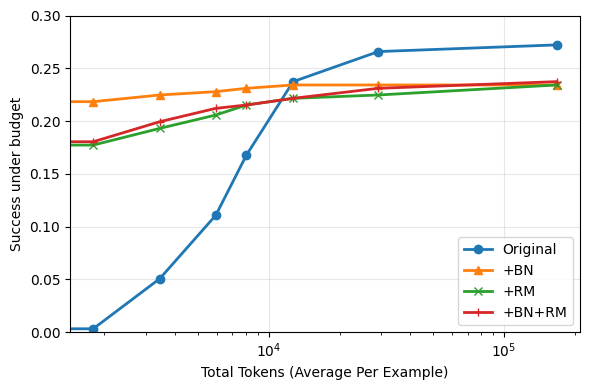

Output Tokens — normalized AUC: Original: 0.253, +BN: 0.234, +RM: 0.229, +BN+RM: 0.232


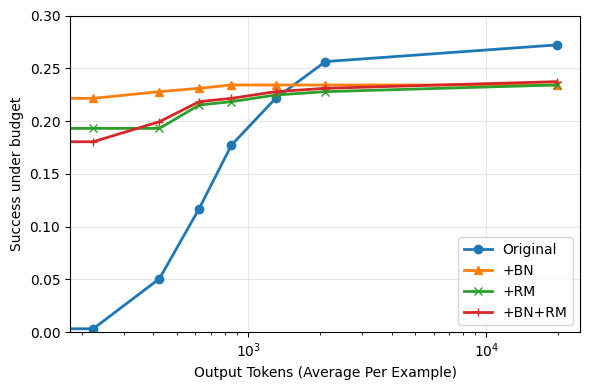

Model Invocations — normalized AUC: Original: 0.229, +BN: 0.233, +RM: 0.225, +BN+RM: 0.227


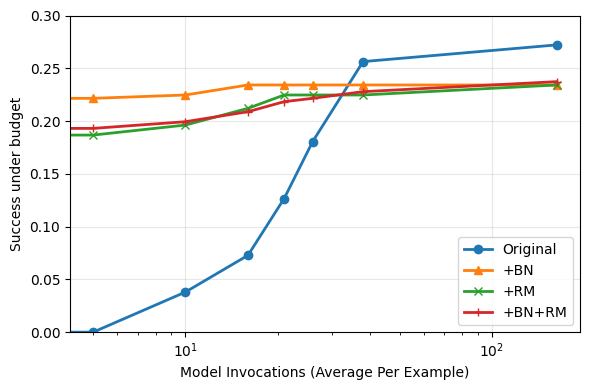

Wall Time (s) — normalized AUC: Original: 0.256, +BN: 0.234, +RM: 0.229, +BN+RM: 0.232


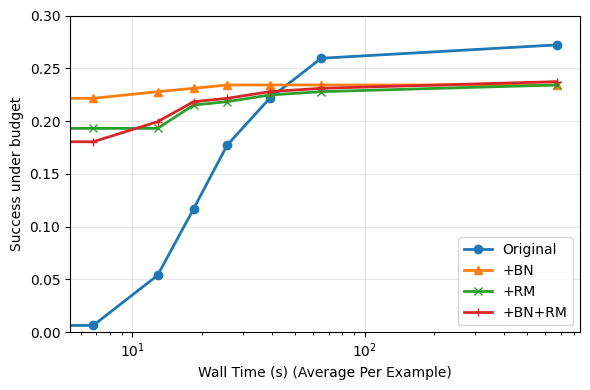

In [ ]:
from langagent.visualize import compute_tradeoff_curves
models_metrics = {
    "Original": metrics_rest,
    "+BN": metrics_rest_bn,
    "+RM": metrics_rest_rm,
    "+BN+RM": metrics_rest_bn_rm
}
for key, label in [("total_tokens","Total Tokens"),
                   ("output_tokens","Output Tokens"),
                   ("num_calls","Model Invocations"),
                   ("running_time","Wall Time (s)")]:
    B, C, A = compute_tradeoff_curves(models_metrics, cost_key=key, n_points=15)
    print(f"{label} — normalized AUC: " + ", ".join(f"{m}: {A[m]:.3f}" for m in C))
    plot_tradeoff_curves(B, C, xlabel=label, title=None, y_limits=(0, 0.3))
# --------------------------

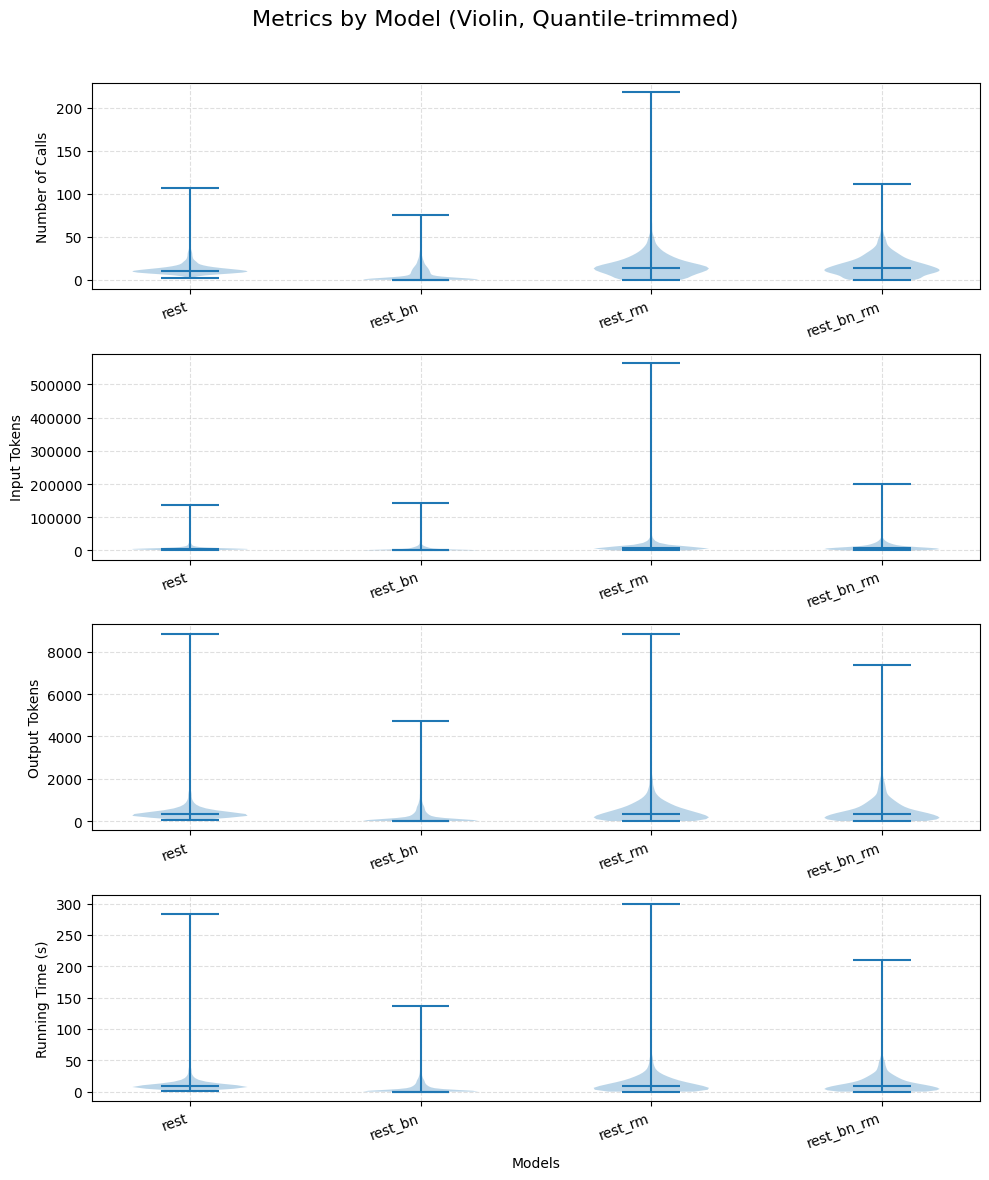

In [ ]:
violin_plot_metrics_over_examples_for_multiple_models(models_metrics, q_low=None, q_high=None)

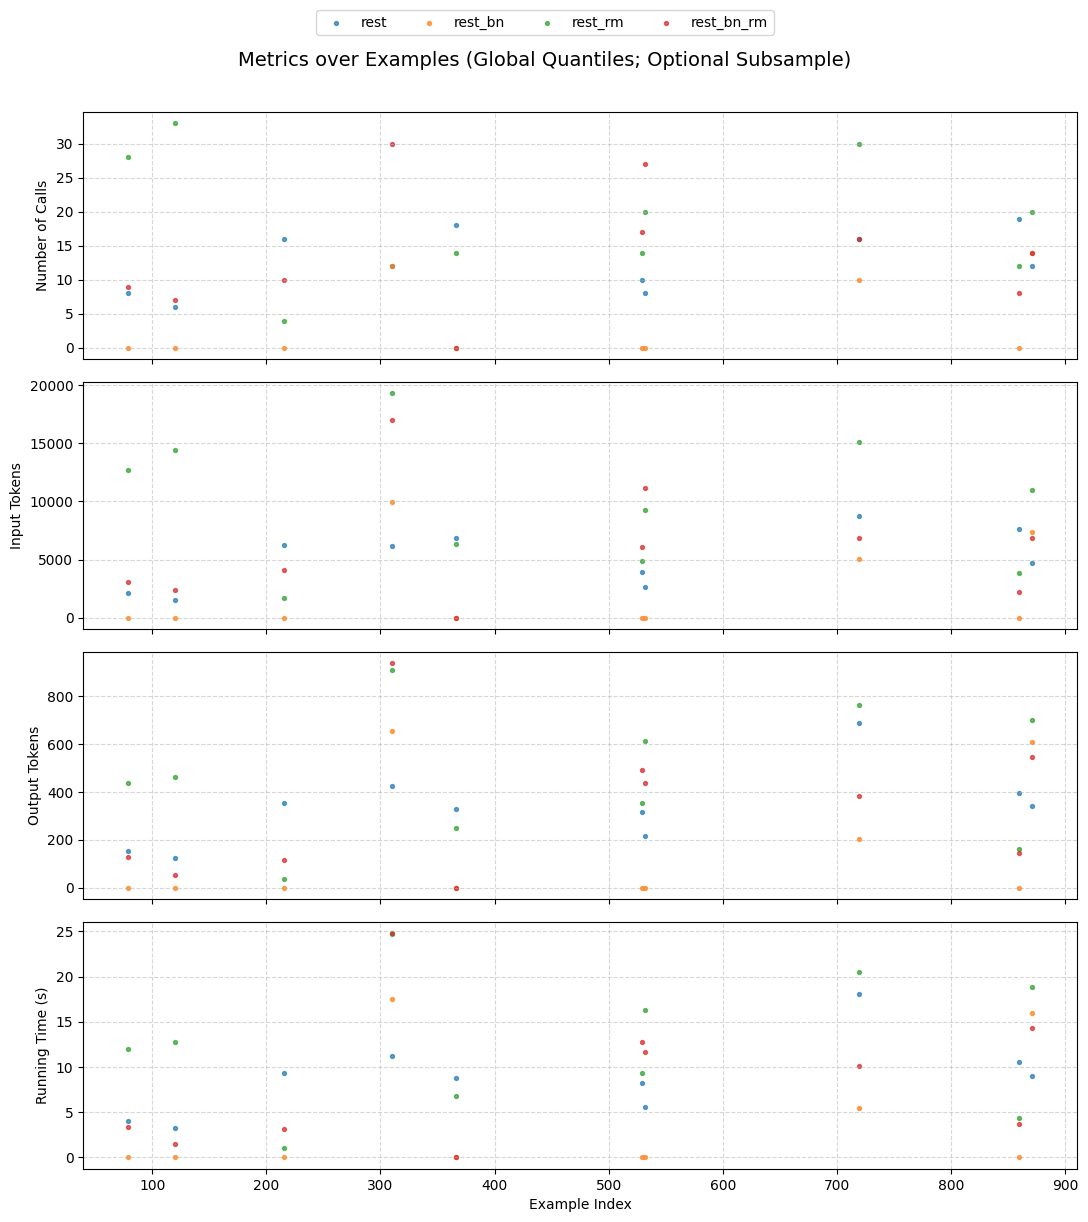

In [7]:
plot_metrics_over_examples_for_multiple_models(models_metrics, sample_n=10)


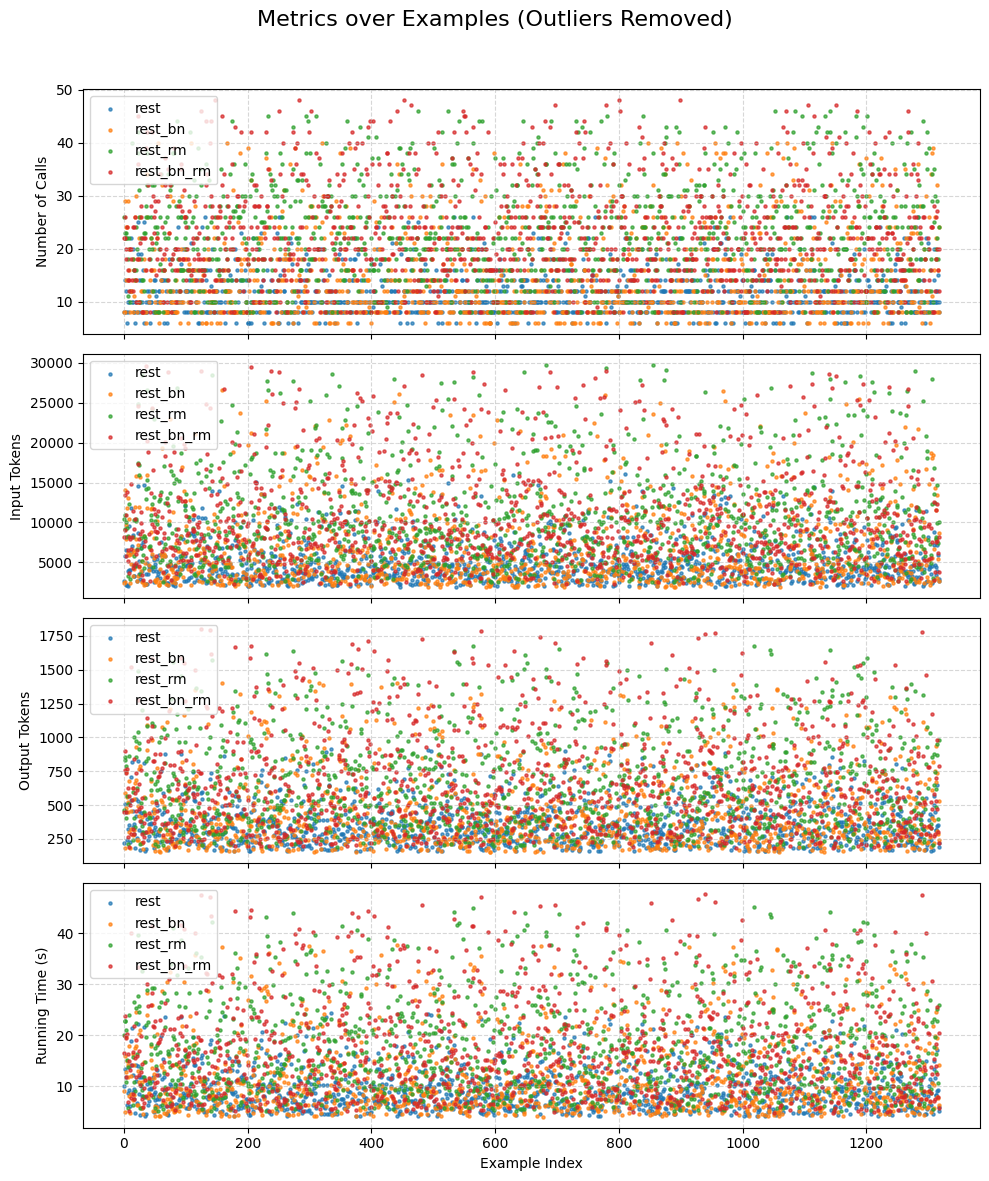

In [18]:
plot_metrics_over_examples_for_multiple_models(models_metrics)


Path Visualization:
Node 0 (reward: None, cum rewards: None): None -> []
Node 1 (reward: None, cum rewards: None): How many pieces of 2x4 can he buy with $24? -> [RapStep(sub_question='How many pieces of 2x4 can he buy with $24?', sub_answer='A 2 x 4 costs $4, so he can buy $24 / $4 = 6 pieces. The answer is 6.', confidence=1.0)]
Node 2 (reward: None, cum rewards: None): How many popsicle sticks can he make with the 2x4s? -> [RapStep(sub_question='How many pieces of 2x4 can he buy with $24?', sub_answer='A 2 x 4 costs $4, so he can buy $24 / $4 = 6 pieces. The answer is 6.', confidence=1.0), RapStep(sub_question='How many popsicle sticks can he make with the 2x4s?', sub_answer='He can get 200 sticks from a 2 x 4 piece of wood and he can buy 6 pieces, so he can make 200 * 6 = 1200 sticks. The answer is 1200.', confidence=1.0)]
Node 3 (reward: None, cum rewards: None): Now we can answer the question: What is the most popsicle sticks he can make if he buys the cheapest lumber? -> [RapStep

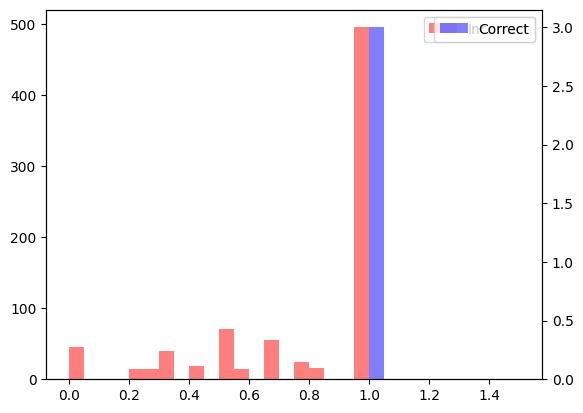

In [ ]:
# from langagent.search.mcts import visualize_node, visualize_path
def visualize_node(node) -> str:
    verbalized_state = (
        f"Node {node.id} "
        f"(reward: {getattr(node, 'reward', 'None')}, "
        f"cum rewards: {getattr(node, 'cum_rewards', 'None')}): "
        f"{node.action} -> {node.state}"
    )

    return verbalized_state

def visualize_path(path: list):
    text = "Path Visualization:\n"
    
    text += "\n".join(visualize_node(node) for node in path)
    is_continuous_pct = pct_continuous(path)
    text += f"\nIs Continuous: {is_continuous_pct:.2f}\n"
    return text

def pct_continuous(path: list):
    """ Percentage of nodes that are continuous along the reasoning path"""
    return sum(getattr(node, 'is_continuous', False) for node in path) / (len(path)-1)  # -1 to exclude root node (always empty)

print(visualize_path(df_rap_incorrect['final_trace'].iloc[0]))

# distribution of pct_continuous
all_pct_continuous_incorrect = []
for i in range(len(df_rap_incorrect)):
    all_pct_continuous_incorrect.append(pct_continuous(df_rap_incorrect['final_trace'].iloc[i]))

all_pct_continuous_correct = []
for i in range(len(df_rap_correct)):
    all_pct_continuous_correct.append(pct_continuous(df_rap_correct['final_trace'].iloc[i]))

# plot histogram for two distributions  (overlap with transparency) with two separate (twin) axes

figure, ax = plt.subplots()
ax.hist(all_pct_continuous_incorrect, bins=20, alpha=0.5, color='r', label='Incorrect')
ax2 = ax.twinx()
ax2.hist(all_pct_continuous_correct, bins=20, alpha=0.5, color='b', label='Correct')
ax.legend()
ax2.legend()
plt.show()

In [23]:
df_rap_incorrect_continuous

,index,question,answer,output
0,2,Josh decides to try flipping a house. He buys...,70000,65000
1,12,Carlos is planting a lemon tree. The tree will...,13,12
2,13,Melanie is a door-to-door saleswoman. She sold...,18,None
3,37,John plans to sell all his toys and use the mo...,2,0
4,56,Peter plans to go to the movies this week. He ...,3,None
...,...,...,...,...
122,1288,Every day Charisma meditates for 15 minutes wh...,34,2040
123,1301,"Randy has 9 oatmeal cookies, 4 chocolate chip ...",23,None
124,1309,The girls are trying to raise money for a carn...,2280,2180
125,1310,Aaron and Vanessa were relay race partners on ...,64,32
